**<font color = black size=6>实验五：神经网络中的前向传播与后向传播</font>**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.preprocessing import OneHotEncoder

**<font color = blue size=4>第一部分:PyTorch介绍</font>**

这里介绍一小部分PyTorch常用的库和函数，更多需求可参阅[PyTorch官方教程](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)以及[PyTorch官方文档](https://pytorch.org/docs/stable/index.html)。

In [2]:
import torch # 导入的是 torch 而不是 pytorch
print(torch.__version__) # 输出当前pytorch的版本

e:\Anaconda3\envs\VoiceRecognition\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.12.1+cu116


1.Tensor

Tensor与NumPy中的ndarray很相似，但Tensor可以利用GPU来加速计算（虽然本门课不用）。

1.1. Tensor的创建

In [3]:
# 创建一个未初始化的Tensor
x = torch.empty(2, 3)
print(x)

# 从一个列表创建Tensor
x = torch.tensor([[1,2,3],[4,5,6]])
print(x)

# 创建一个随机Tensor
x = torch.rand([3, 4])
print(x)

# 创建一个全零Tensor
x = torch.zeros([2, 3])
print(x)

# 创建一个全一Tensor
x = torch.ones([2, 3])
print(x)

tensor([[3.3703e-06, 1.0081e-08, 2.5668e-09],
        [1.3458e+22, 5.1659e-11, 4.2330e+21]])
tensor([[1, 2, 3],
        [4, 5, 6]])
tensor([[0.6392, 0.2632, 0.4158, 0.0573],
        [0.9262, 0.1786, 0.6161, 0.3162],
        [0.9791, 0.7191, 0.8257, 0.3324]])
tensor([[0., 0., 0.],
        [0., 0., 0.]])
tensor([[1., 1., 1.],
        [1., 1., 1.]])


1.2. Tensor的运算

In [4]:
# 加减法
x = torch.tensor([[1,2,3],[4,5,6]])
y = torch.tensor([[6,5,4],[3,2,1]])
print(x + y)
print(x - y)

# 对应位置相乘
print(x * y)
print(x.mul(y))

# 矩阵乘法
print(x.matmul(y.T))
print(x @ y.T)

# reshape
print(x.reshape(3, 2))

# 拼接
print(torch.cat([x,y], dim=0)) # 纵向拼接
print(torch.cat([x,y], dim=1)) # 横向拼接

tensor([[7, 7, 7],
        [7, 7, 7]])
tensor([[-5, -3, -1],
        [ 1,  3,  5]])
tensor([[ 6, 10, 12],
        [12, 10,  6]])
tensor([[ 6, 10, 12],
        [12, 10,  6]])
tensor([[28, 10],
        [73, 28]])
tensor([[28, 10],
        [73, 28]])
tensor([[1, 2],
        [3, 4],
        [5, 6]])
tensor([[1, 2, 3],
        [4, 5, 6],
        [6, 5, 4],
        [3, 2, 1]])
tensor([[1, 2, 3, 6, 5, 4],
        [4, 5, 6, 3, 2, 1]])


1.3. Tensor与ndarray的相互转换

In [5]:
x = torch.tensor([[1,2,3],[4,5,6]])
print(x)

# 从Tensor转换到ndarray
y = x.numpy()
print(y)

# Tensor与ndarray是共享空间的
x[:]=0
print(y)

# 从ndarray到Tensor
z = torch.from_numpy(y)
print(z)

tensor([[1, 2, 3],
        [4, 5, 6]])
[[1 2 3]
 [4 5 6]]
[[0 0 0]
 [0 0 0]]
tensor([[0, 0, 0],
        [0, 0, 0]])


2.自动求梯度

In [6]:
a = torch.tensor([[1.,2.]], requires_grad=True) # 把requires_grad设为True, 开始跟踪基于它的所有运算
b = torch.tensor([[3.],[4.]])
c = torch.tensor(5., requires_grad=True)
y = a @ b + c
y.backward() #自动计算梯度
print(a.grad, c.grad) #输出叶子节点a和c的梯度

# 可支持多种运算求梯度，如torch.mean(),torch.sum()等
a = torch.ones(20, requires_grad=True)
z = torch.sum(torch.sigmoid(a))
z.backward()
print(a.grad)

# 多次求梯度时梯度会累加，可使用tensor.grad.zero_()进行手动清零
x = torch.tensor(2., requires_grad=True)
y = x ** 2
y.backward()
print(x.grad)
z = x + 3
z.backward()
print(x.grad)
x.grad.zero_()
print(x.grad)

tensor([[3., 4.]]) tensor(1.)
tensor([0.1966, 0.1966, 0.1966, 0.1966, 0.1966, 0.1966, 0.1966, 0.1966, 0.1966,
        0.1966, 0.1966, 0.1966, 0.1966, 0.1966, 0.1966, 0.1966, 0.1966, 0.1966,
        0.1966, 0.1966])
tensor(4.)
tensor(5.)
tensor(0.)


3. 神经网络（官方教程中的例子）

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 继承自nn.Module
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 卷积层
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        # nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)
        # 其中in_features表示有多少个输入，out_features表示该层有多少个神经元
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [8]:
# 该神经网络中可学习的参数可以通过net.parameters()访问
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

10
torch.Size([6, 1, 5, 5])


In [9]:
# 随机生成一个输入送入net中，除了第0维是样本个数外，其余维度要与forward()参数中x的维度对应上
input = torch.randn(1, 1, 32, 32) # 1个样本，该样本是有1个通道的32×32的图像
out = net(input) # 进行一次forward()前向传播
print(out)

tensor([[-0.0483,  0.0103, -0.0453,  0.0303,  0.0582, -0.0657,  0.0174,  0.0330,
         -0.0856, -0.0084]], grad_fn=<AddmmBackward0>)


In [10]:
net.zero_grad() # 手动清零神经网络中参数的梯度
out.backward(torch.randn(1, 10)) # 用随机梯度进行一次backward()后向传播来计算梯度

In [11]:
output = net(input)
target = torch.randn(10)  # a dummy target, for example
target = target.view(1, -1)  # make it the same shape as output
# nn模块提供了许多种类的损失函数，如nn.CrossEntropyLoss()、nn.MSELoss()等等
criterion = nn.MSELoss()

loss = criterion(output, target)

print(loss)

tensor(1.0651, grad_fn=<MseLossBackward0>)


计算图如下：
input -> conv2d -> relu -> maxpool2d -> conv2d -> relu -> maxpool2d
      -> flatten -> linear -> relu -> linear -> relu -> linear
      -> MSELoss
      -> loss

In [12]:
# 查看计算图中的函数
print(loss.grad_fn)  # MSELoss
print(loss.grad_fn.next_functions[0][0])  # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  # ReLU

In [13]:
net.zero_grad()     # zeroes the gradient buffers of all parameters

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

# 进行一次后向传播
loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
tensor([0., 0., 0., 0., 0., 0.])
conv1.bias.grad after backward
tensor([0.0022, 0.0145, 0.0016, 0.0012, 0.0140, 0.0069])


In [14]:
# 用梯度下降法(手动)更新net中的参数
learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)

In [15]:
# 用PyTorch的优化器来更新net中的参数
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

# 在每次循环中应该做的事:
optimizer.zero_grad()   # 把梯度清零
output = net(input) # 进行一次前向传播
loss = criterion(output, target) # 计算误差
loss.backward() # 后向传播
optimizer.step()    # 参数更新

**<font color = blue size=4>第二部分:实验内容</font>**

[Red Wine Quality](https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009)是一个关于红酒品质的数据集，总共有1599个样本，每个样本包含11个(都是连续的)特征以及1个标签，每个标签的取值是连续的。本次实验已经按照8：2的比例划分成了训练数据集'wine_train.csv'以及测试数据集'wine_test.csv'，且每个数据集都已经做了归一化处理。

<span style="color:yellow">1) 读入训练数据集'wine_train.csv'与测试数据集'wine_test.csv'。</span>

In [16]:
# -- Your code here --
#读入数据集
from torch.autograd import Variable
import time
import matplotlib
wine_trainframe=pd.read_csv("wine_train.csv")
wine_testframe=pd.read_csv("wine_test.csv")

wine_train=torch.from_numpy(np.array(wine_trainframe))
wine_test=torch.from_numpy(np.array(wine_testframe))
#print(wine_train[0:10])
feature=wine_train[0:10, :-1]
print(wine_train.shape[0])

1279


<span style="color:yellow">2) 利用线性层和激活函数搭建一个神经网络，要求输入和输出维度与数据集维度一致，而神经网络深度、隐藏层大小、激活函数种类等超参数自行调整。</span>

In [17]:
# -- Your code here --
# 继承自nn.Module
#定义自己的网络
class myNet(nn.Module):
    def __init__(self):
        super(myNet, self).__init__()
        '''
        卷积层
        1 input image channel, 6 output channels, 5x5 square convolution
        kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        an affine operation: y = Wx + b
        nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)
        其中in_features表示有多少个输入，out_features表示该层有多少个神经元
        '''
        #采取四个线性连接层，且用relu函数作为激活函数
        self.fc1 = nn.Linear(11, 100)  
        self.fc2 = nn.Linear(100, 84)
        self.fc3 = nn.Linear(84, 20)
        self.fc4 = nn.Linear(20 ,1)

    def forward(self, x):
        '''
        # Max pooling over a (2, 2) window
        #x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square, you can specify with a single number
        #x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        #x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        '''
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x =F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

         
def mybploss(out, quality):
    return 0.5*(pow((out-quality),2))

<span style="color:yellow">3) 用梯度下降法进行模型参数更新，记下每轮迭代中的训练损失和测试损失。</span>

In [18]:
#网络参数数量
def get_parameter_number(net):
    total_num = sum(p.numel() for p in net.parameters())
    trainable_num = sum(p.numel() for p in net.parameters() if p.requires_grad)
    return  total_num,  trainable_num
#选择示例网络
net = myNet()
net = net.double()      #从float到double
print(net)
#use_gpu = torch.cuda.is_available()    使用gpu训练
total_num,  trainable_num=get_parameter_number(net)
print('Total:', total_num, 'Trainable:', trainable_num)   #打印出总的变量数和需要求导的变量
#设置损失函数
#criterion = mybploss()
#设置网络优化方式
learingrate = 0.01
optimizer = torch.optim.SGD(net.parameters(), lr=learingrate) #学习率0.1 0.01
'''for param in net.parameters():
    param.requires_grad = False'''
#optimizer = optim.SGD(filter(lambda p: p.requires_grad, net.parameters()), lr=learingrate, momentum=0.9, weight_decay=5e-4)
#if(use_gpu):
    #net = net.cuda()
    #criterion = criterion.cuda()

#acces = []
#设置训练和预测损失值
eval_losses = []
#eval_acces = []
losses = []
trainlosses=[]
start = time.time()
epoch=30
#开始训练 
for e in range(epoch):
    train_loss = 0
    net.train()
    for j in range(wine_train.shape[0]):
        #if (use_gpu):
            #feature, quality = feature.cuda(),quality.cuda()
        #im = Variable(im)
        #label = Variable(label)
        # 前向传播
        feature=wine_train[j, : -1]
        quality=wine_train[j, -1]
        out = net(feature)
        loss = mybploss(out, quality)
        # 反向传播
        optimizer.zero_grad()   #网络优化随机梯度下降！
        loss.backward()
        optimizer.step()
        '''for p in net.parameters():
            if (p.requires_grad):
                p=p-learingrate*p.grad.data
                p.grad.data.zero_()     手动梯度下降'''  
        # 记录误差
        train_loss += loss.item()     
    losses.append(train_loss /wine_train.shape[0])
    #acces.append(train_acc / len(train_data))
    #print(trainlosses)
    #将网络切换为预测模式！
    net.eval()
    eval_loss=0
    for k in range(wine_test.shape[0]):
        feature=wine_train[k, : -1]
        quality=wine_train[k, -1]
        out = net(feature)
        loss = mybploss(out, quality)
        eval_loss+=loss.item()
    eval_losses.append(eval_loss/wine_test.shape[0])
    #完成一次训练和预测（epoch）
    print('***** One epoch has finished ******')
    print('epoch: {}, Train Loss: {:.6f},  Eval Loss: {:.6f},'.format(e, train_loss / wine_train.shape[0], eval_loss /wine_test.shape[0]))
    trainlosses.append(train_loss / wine_train.shape[0])    #注意每个循环的变量要不一样！！
end = time.time()
print('The code run{:.2f}s'.format(end - start))
#输出对应的loss值
print("the trainlosses is :\n", trainlosses)
print("the eval losses is :\n", eval_losses)


myNet(
  (fc1): Linear(in_features=11, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=1, bias=True)
)
Total: 11405 Trainable: 11405
***** One epoch has finished ******
epoch: 0, Train Loss: 0.017035,  Eval Loss: 0.013167,
***** One epoch has finished ******
epoch: 1, Train Loss: 0.012157,  Eval Loss: 0.012592,
***** One epoch has finished ******
epoch: 2, Train Loss: 0.011643,  Eval Loss: 0.011977,
***** One epoch has finished ******
epoch: 3, Train Loss: 0.011099,  Eval Loss: 0.011346,
***** One epoch has finished ******
epoch: 4, Train Loss: 0.010545,  Eval Loss: 0.010708,
***** One epoch has finished ******
epoch: 5, Train Loss: 0.010020,  Eval Loss: 0.010131,
***** One epoch has finished ******
epoch: 6, Train Loss: 0.009587,  Eval Loss: 0.009683,
***** One epoch has finished ******
epoch: 7, Train Loss: 0.009279,  Eval Loss: 0.009374,


<span style="color:yellow">4) 画出训练损失和测试损失关于迭代轮数的折线图。</span>

Text(0.5, 1.0, 'loss vs eval epoch')

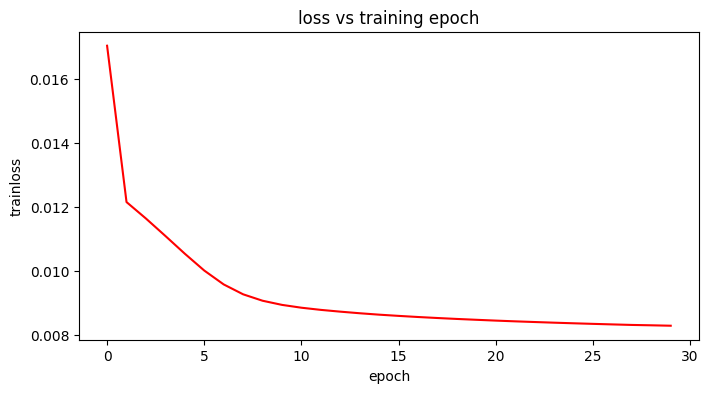

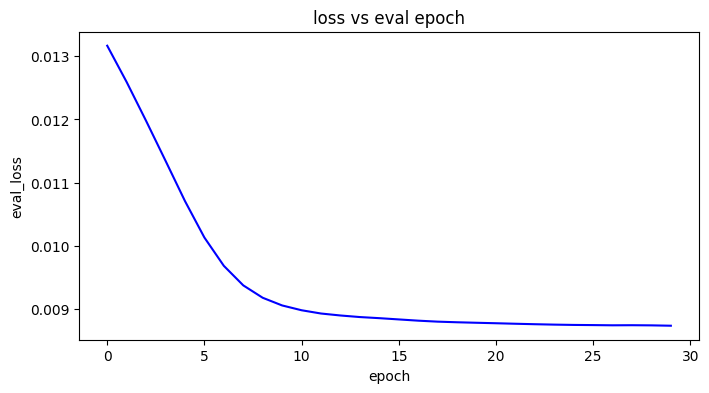

In [19]:
# -- Your code here --
fig1,ax=plt.subplots(figsize=(8,4))
ax.plot(np.arange(epoch), trainlosses, 'r')
ax.set_xlabel('epoch')
ax.set_ylabel('trainloss')
ax.set_title('loss vs training epoch')

fig2, bx=plt.subplots(figsize=(8,4))
bx.plot(np.arange(epoch), eval_losses, 'b')
bx.set_xlabel('epoch')
bx.set_ylabel('eval_loss')
bx.set_title('loss vs eval epoch')